# Data

## Introduction
In financial engineering, data is the lifeblood of analysis. Whether we are backtesting trading strategies, pricing derivatives, or running risk simulations, we constantly need to **load, transform, and save data efficiently**.

Different storage formats exist, each with trade-offs in **speed, memory usage, readability, and interoperability**. In this notebook, we will explore:
- Binary files with NumPy (`.npy`, `.npz`)
- CSV (Comma-Separated Values)
- JSON (JavaScript Object Notation)
- Parquet (columnar storage, optimized for big data)

We will motivate each format with **financial examples** such as stock prices, portfolio weights, and risk factor simulations.

---
## 1. NumPy Binary Files (`.npy`, `.npz`)

### Features
- NumPy provides a native binary format for storing arrays.
- `.npy` stores a single array, while `.npz` stores multiple arrays in a compressed archive.
- Advantages: **extremely fast read/write**, preserves **data types and shapes**.
- Limitation: Not human-readable, not portable outside python.

###  Example
Imagine we simulate **Monte Carlo paths** for asset prices. These are large arrays of floating-point numbers. Storing them in CSV would be inefficient and slow. NumPy binary files are ideal here. `np.save` and `np.load` allow to save/load


In [1]:
import numpy as np

# Simulate Monte Carlo paths for a stock price
np.random.seed(42)
n_paths, n_steps = 1000, 252
paths = np.cumprod(1 + 0.001 + 0.02*np.random.randn(n_paths, n_steps), axis=1)

# Save to .npy
np.save("monte_carlo_paths.npy", paths)

# Load back
loaded_paths = np.load("monte_carlo_paths.npy")
print("Shape:", loaded_paths.shape)

Shape: (1000, 252)


---
# 2. Binary Files with universal compatibility, C-array style

### Features

- NumPy provides a  binary format for storing arrays.
- Advantages: **extremely fast read/write** and universal readibility across programming languages
- Limitation: Not human-readable, the user needs to know beforehand the structrure and data types of the object
### Example

In [2]:
paths.tofile("monte_carlo_paths.data")

In [3]:
np.fromfile("monte_carlo_paths.data", dtype=np.float64)

array([1.01093428, 1.00914969, 1.02323114, ..., 1.85957682, 1.84582295,
       1.91064418], shape=(252000,))

#### If we misspecify the types, it will read nonsensical content. For instance if we use float32 instead of float64 it will read twice as many nonensical values 

In [4]:
np.fromfile("monte_carlo_paths.data", dtype=np.float32)

array([ 3.7598936e+27,  1.8763667e+00,  9.2845219e-16, ...,
        1.9807278e+00, -2.6257864e-18,  1.9888304e+00],
      shape=(504000,), dtype=float32)

---
## 3. CSV (Comma-Separated Values)

### Features
- CSV is the most common format for tabular data.
- Human-readable, widely supported (Excel, R, Python, databases).
- Limitation: Large files are slow to parse, no type information beyond text.

### Example 1
Same Monte Carlo path example

In [5]:
np.savetxt("monte_carlo.csv", paths, delimiter=",")

### Example 2
Daily **stock prices** or **portfolio holdings** are often shared as CSV files between analysts, traders, and risk managers.

In [6]:
import pandas as pd

# Create a DataFrame of stock prices
dates = pd.date_range("2020-01-01", periods=5)
prices = pd.DataFrame({
    "AAPL": [300, 305, 310, 308, 315],
    "MSFT": [160, 162, 165, 163, 167]
}, index=dates)

# Save to CSV
prices.to_csv("stock_prices.csv")

# Load back
loaded_prices = pd.read_csv("stock_prices.csv", index_col=0, parse_dates=True)
loaded_prices

,AAPL,MSFT
2020-01-01,300,160
2020-01-02,305,162
2020-01-03,310,165
2020-01-04,308,163
2020-01-05,315,167


---
## 4. JSON (JavaScript Object Notation)

### Features
- JSON is a human-readable text-based format for hierarchical data.
- Useful for **metadata, configurations, structured but non-tabular data**.
- Limitation: Not efficient for large numerical arrays.

### Example
Storing **portfolio weights** or **risk model parameters** in JSON makes sense, since they are structured but relatively small.

In [7]:
import json

portfolio = {
    "portfolio_name": "Tech Growth",
    "weights": {"AAPL": 0.4, "MSFT": 0.35, "GOOG": 0.25},
    "currency": "USD"
}

# Save to JSON
with open("portfolio.json", "w") as f:
    json.dump(portfolio, f, indent=4)

# Load back
with open("portfolio.json", "r") as f:
    loaded_portfolio = json.load(f)

loaded_portfolio

{'portfolio_name': 'Tech Growth',
 'weights': {'AAPL': 0.4, 'MSFT': 0.35, 'GOOG': 0.25},
 'currency': 'USD'}

## 5. Parquet (Columnar Storage)

### Features
- Parquet is a binary, columnar storage format.
- Advantages: **high compression**, **fast queries**, optimized for big data.
- Widely used in financial institutions for storing **tick data** or **large historical datasets**.
- Limitation: Requires libraries like `pyarrow` or `fastparquet`to be used with different programming languages

### Example
Storing **high-frequency trading data** or **large historical datasets** (millions of rows) is best done in Parquet.

In [8]:
pd.DataFrame(paths).to_parquet('prices.parquet',
              compression=None)  

In [9]:
pd.read_parquet('prices.parquet')

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,1.010934,1.009150,1.023231,1.055423,1.051535,1.047663,1.081800,1.099486,1.090262,1.103183,...,1.195206,1.217096,1.189096,1.182330,1.172281,1.158136,1.200187,1.211108,1.181778,1.204654
1,1.043443,1.066033,1.034705,1.025719,1.052735,1.038888,1.049148,1.066451,1.047747,1.047548,...,1.406166,1.422729,1.394637,1.390723,1.367758,1.331299,1.357291,1.410481,1.372439,1.389264
2,0.987987,0.979350,0.968726,0.952955,0.954833,0.939919,0.945943,0.945939,0.942364,0.926201,...,0.882390,0.869942,0.860172,0.836833,0.822218,0.800813,0.785984,0.803332,0.788882,0.831204
3,1.010866,1.015614,0.999195,1.014189,1.003527,1.006979,1.059545,1.058569,1.083959,1.069799,...,2.345149,2.374350,2.443175,2.490799,2.496261,2.466458,2.503368,2.525572,2.573315,2.608578
4,1.021991,1.012073,1.039751,1.044900,1.089314,1.075388,1.113800,1.119323,1.105859,1.096263,...,1.946823,1.981225,1.904205,1.920355,1.969427,1.923750,1.990026,2.008693,1.982379,1.982150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.029745,1.013223,1.003920,1.011885,1.050742,1.087804,1.068689,1.053635,1.068808,1.091005,...,1.115145,1.113766,1.148106,1.168639,1.161663,1.140401,1.156502,1.180152,1.200710,1.239248
996,1.007951,1.009531,1.004937,1.024978,1.043920,1.042832,1.113726,1.099591,1.140563,1.120447,...,1.154214,1.184377,1.135682,1.129662,1.129138,1.146047,1.174430,1.176844,1.196802,1.236541
997,0.972525,0.987230,0.965546,0.989908,0.958191,0.924263,0.923308,0.922084,0.897505,0.870742,...,0.567994,0.574436,0.565370,0.571113,0.563160,0.542577,0.544579,0.549933,0.537369,0.552655
998,1.022842,1.013370,1.071251,1.045678,1.021158,0.997019,0.989661,0.950809,0.922326,0.920838,...,1.070140,1.077323,1.060979,1.057014,1.050797,1.019936,1.033760,1.023514,1.044849,1.055920


### Parquet has a richer metadata storate in the file, so that it can optimize reading

In [10]:
from pyarrow import parquet
import os

file = parquet.ParquetFile('prices.parquet')
metadata = file.metadata
metadata

  created_by: parquet-cpp-arrow version 22.0.0
  num_columns: 252
  num_rows: 1000
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 109290

In [11]:
from pyarrow import parquet

# Open the Parquet file
parquet_file = 'prices.parquet'
metadata = parquet.ParquetFile(parquet_file).metadata

print(metadata)
# Prepare data for tabular display
table_data = []
headers = [
    "Column Index", "Name", "Physical Type", "Logical Type", "Num Values",
    "Null Count", "Min", "Max", "Compression", "Encodings", "File Offset",
    "Total Compressed Size", "Total Uncompressed Size"
]

for column_index in range(metadata.num_columns):
    column_meta = metadata.row_group(0).column(column_index)
    name = metadata.schema.column(column_index).name
    physical_type = column_meta.physical_type
    logical_type = column_meta.statistics.logical_type if column_meta.statistics else "N/A"
    num_values = column_meta.statistics.num_values if column_meta.statistics else "N/A"
    null_count = column_meta.statistics.null_count if column_meta.statistics else "N/A"
    min_val = column_meta.statistics.min if column_meta.statistics else "N/A"
    max_val = column_meta.statistics.max if column_meta.statistics else "N/A"
    compression = column_meta.compression
    encodings = ", ".join(column_meta.encodings)
    file_offset = column_meta.dictionary_page_offset
    total_compressed_size = column_meta.total_compressed_size
    total_uncompressed_size = column_meta.total_uncompressed_size

    table_data.append([
        column_index, name, physical_type, logical_type, num_values, null_count,
        min_val, max_val, compression, encodings, file_offset,
        total_compressed_size, total_uncompressed_size
    ])

pd.DataFrame(table_data,columns=headers)

  created_by: parquet-cpp-arrow version 22.0.0
  num_columns: 252
  num_rows: 1000
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 109290


,Column Index,Name,Physical Type,Logical Type,Num Values,Null Count,Min,Max,Compression,Encodings,File Offset,Total Compressed Size,Total Uncompressed Size
0,0,0,DOUBLE,None,1000,0,0.942062,1.070037,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",4,9343,9343
1,1,1,DOUBLE,None,1000,0,0.900787,1.086646,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",9347,9343,9343
2,2,2,DOUBLE,None,1000,0,0.902563,1.134816,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",18690,9343,9343
3,3,3,DOUBLE,None,1000,0,0.873617,1.146738,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",28033,9343,9343
4,4,4,DOUBLE,None,1000,0,0.868566,1.140215,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",37376,9343,9343
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,247,247,DOUBLE,None,1000,0,0.461121,2.882834,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",2307725,9343,9343
248,248,248,DOUBLE,None,1000,0,0.451747,2.858695,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",2317068,9343,9343
249,249,249,DOUBLE,None,1000,0,0.448725,2.854402,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",2326411,9343,9343
250,250,250,DOUBLE,None,1000,0,0.437465,2.890919,UNCOMPRESSED,"PLAIN, RLE, RLE_DICTIONARY",2335754,9343,9343


---
# Dealing with big data

#### For the scope of this course we will consider big data any data that doesn´t fit into the computer RAM e.g. cannot be loaded directly

In [12]:
np.random.seed(0)

In [14]:
#generate some large data file

with open("demo_big_data.data", "ab") as f:
  for i in range(10):
    f.write(np.random.normal(0,1,200000000).tobytes())



In [15]:
np.fromfile("demo_big_data.data",dtype=np.float64)

array([ 0.19068548,  0.87969952,  1.21541939, ...,  0.86881366,
        0.61031515, -0.14317777], shape=(2000000000,))

#### Say we just need 10 elements, the `offset` argument in `np.fromfile` allows us to define in which **bytes** we want to start reading the file

In [16]:
np.fromfile("demo_big_data.data",dtype=np.float64,offset=0,count=10)# first 10 elements

array([ 1.90685478e-01,  8.79699524e-01,  1.21541939e+00,  1.63590792e+00,
        1.56611898e-03,  7.04315973e-01,  7.84031368e-01, -1.56275269e+00,
        6.59155010e-01,  1.50592318e+00])

In [17]:
np.fromfile("demo_big_data.data",dtype=np.float64,offset=8,count=10) #elements 2-11

array([ 8.79699524e-01,  1.21541939e+00,  1.63590792e+00,  1.56611898e-03,
        7.04315973e-01,  7.84031368e-01, -1.56275269e+00,  6.59155010e-01,
        1.50592318e+00,  1.17413280e+00])

In [18]:
np.fromfile("demo_big_data.data",dtype=np.float64,offset=8*100000,count=10) #elements 100001-100011

array([ 0.9099024 , -0.90035097, -0.54186436, -0.66809116,  0.34604182,
        0.30692567, -0.87252142, -1.05813025,  0.34328769, -0.34708276])

In [19]:
#Even with a large number of elements this is efficient

In [20]:
import numpy as np
np.fromfile("demo_big_data.data",dtype=np.float64,offset=0,count=20000000)# first 20000000 elements

array([ 0.19068548,  0.87969952,  1.21541939, ...,  1.49694121,
       -0.84787141,  0.29743691], shape=(20000000,))

--- 
# Row vs column data storage
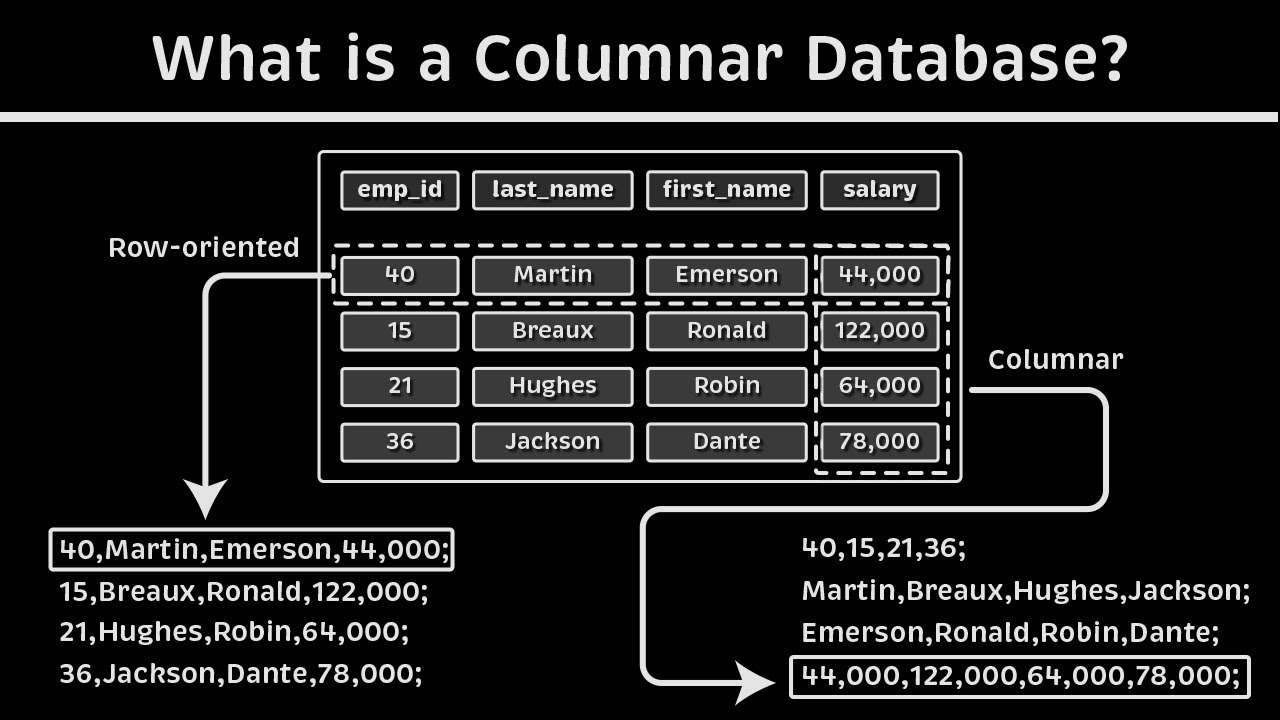

#### There is a trade-off between storage type (columnar vs. row) and query efficienty columns vs row. If data is stored in a row sequence and we request rows, the the query efficiency will be high. However if we store data in column sequence and we request a row it will be inneficient

### Example
Let´s take the previous example and assume "demo_big_data.data" file contains a 10 column matrix and we want to retrieve the 100 first column values. There is no explicit way when loading the file to jump "n" elements, we have to "read" them and disregard them. We can do so in the next example

In [4]:
dt = np.dtype([ ('data', 'f8'), ("void", "V72")])# "V72" is a void type of sice 72 bytes
data = np.fromfile("demo_big_data.data", dtype=dt,count=100)

In [5]:
data["data"]

array([ 0.19068548,  1.1741328 , -0.42362383,  1.44113618, -0.15372047,
       -1.53962604, -2.03561038,  1.20628494, -1.65254915, -0.34271333,
       -1.63653692, -0.2129097 ,  0.02055142,  0.56118805, -0.35186764,
       -0.31401112,  0.77595618, -0.15317878,  0.64810785, -0.15552776,
        1.34046632, -0.65653294,  0.17914959,  0.76818465, -0.59263152,
        1.09044476,  0.70646159,  0.36693834, -0.56730068,  0.31852202,
       -0.59539525, -0.0959153 ,  0.2089251 , -0.4132484 , -1.12590643,
        1.21247914, -0.41791435,  0.94348978,  1.20894467,  0.13912839,
       -1.0834119 ,  0.52849775, -1.45871184,  0.55218431, -1.52909604,
       -0.05365379,  0.72807758,  2.08023018, -0.9521087 ,  1.1395624 ,
        0.15804241,  0.79176348,  1.37672095,  0.35233647,  3.18512211,
        0.55224556, -0.90341845, -0.18300869,  0.60340815,  0.71185121,
        0.61223249,  1.5671515 ,  0.40949065,  2.49127996, -1.39080505,
       -0.88692083, -0.07045383,  0.63888604,  1.63398728,  0.58

If we would like to read all elements in the first column we would need to break the read exercise into smaller chunks

In [6]:
import numpy as np
dt = np.dtype([ ('data', 'f8'), ("_pad", "V72")])
output=np.empty(200000000)
for i in range(20):
    print(i)
    output[i*10000000:(i+1)*10000000]=np.fromfile("demo_big_data.data", dtype=dt,offset=i*80*10000000,count=10000000)["data"]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [7]:
output

array([ 0.19068548,  1.1741328 , -0.42362383, ..., -1.04277498,
        1.2543723 , -1.33963352], shape=(200000000,))

#### As you can see this is much much slower,

#### Bottomline is that you can´t have everything, you need to make a compromise on data storage based on the intended use. Same compromises apply to other data formats like csv

---
## Lazy Evaluation vs. Eager Evaluation

### What is Lazy Evaluation?
Lazy evaluation is a programming paradigm where computations are **not executed immediately** when they are defined. Instead, operations are recorded into a **logical plan** and only executed when the result is explicitly requested (e.g., when calling `.compute()`, `.collect()`, or `.fetch()`).

This approach is especially powerful in **financial engineering**, where datasets can be massive:
- Tick-level trading data with billions of rows
- Monte Carlo simulations with millions of scenarios
- Historical market data spanning decades

By deferring execution, lazy evaluation allows:
- **Efficiency**: Avoids unnecessary intermediate computations.
- **Memory savings**: Large datasets don’t need to be fully loaded into RAM.
- **Optimization**: The system can reorder or combine operations for faster execution.

---

### Libraries That Use Lazy Evaluation

- **Apache Spark**  
  - Spark DataFrames and RDDs are lazily evaluated. Transformations (like `filter`, `map`, `groupBy`) build a logical plan.  
  - Execution happens only when an *action* is called (e.g., `collect()`, `count()`, `saveAsTextFile`).  
  - Widely used in financial institutions for **risk aggregation**, **fraud detection**, and **market data pipelines**.

- **Dask**  
  - Dask DataFrames mimic Pandas but operate lazily on larger-than-memory datasets.  
  - Computations are represented as a task graph and executed only when `.compute()` is called.  
  - Useful for **portfolio backtesting** or **risk simulations** that exceed local memory.

- **Polars**  
  - Polars offers a **lazy API** (`df.lazy()`) where queries are optimized before execution.  
  - The query engine can apply **predicate pushdown** and **projection pruning**, making it extremely fast for analytical workloads.  
  - Ideal for **factor modeling** or **high-frequency data analysis** where performance is critical.

---

### Example
Suppose we want to calculate the **average daily return** of a stock from a massive dataset of tick-level prices:
- With eager evaluation (like Pandas), every intermediate step (loading, filtering, grouping) is executed immediately, consuming memory and time.
- With lazy evaluation (Spark, Dask, Polars), the operations are recorded. The system optimizes the query plan, and only when we request the final result does it execute efficiently.






#### Step 1 create a plan

In [9]:
import pyarrow.dataset as ds
import pyarrow.compute as pc

# 1. Open a Parquet file as a Dataset (lazy, doesn't load all data yet)
dataset = ds.dataset("prices.parquet", format="parquet")

# 2. Build a lazy scan with a filter and projection
#    - Filter: only rows where first colum values > 100
# Build a scanner with filter + projection
scanner = ds.Scanner.from_dataset(
    dataset,
    columns=["0", "1"],
    filter=pc.field("0") > 1.0
)

#### Step 2 create a plan

In [10]:
# Trigger evaluation (materialize results)
table = scanner.to_table()

print(table)

pyarrow.Table
0: double
1: double
----
0: [[1.0109342830602246,1.0434431239402526,1.0108663580176176,1.0219910543063866,1.0121665382504343,...,1.0095979439978886,1.029745280815591,1.0079513338781032,1.0228424491328962,1.0113185523434198]]
1: [[1.0091496948997383,1.0660329426007784,1.0156141167594257,1.012072933397399,1.0147173070669702,...,0.968213282803706,1.0132225344621968,1.0095305776928718,1.0133700679738402,1.0231575760643314]]


In [14]:
table["0"][0]

<pyarrow.DoubleScalar: 1.0109342830602246>

| Aspect                | Lazy Evaluation (Spark, Dask, Polars)                          | Eager Evaluation (NumPy, Pandas)                          |
|-----------------------|---------------------------------------------------------------|-----------------------------------------------------------|
| **Execution Timing**  | Operations are deferred until explicitly requested (`.compute()`, `.collect()`). | Operations are executed immediately when called.          |
| **Memory Usage**      | More efficient: avoids loading entire datasets into memory.    | Loads full data into memory right away.                   |
| **Optimization**      | Query plans can be optimized before execution (predicate pushdown, pruning). | No optimization: each step runs as written.               |
| **Scalability**       | Handles very large datasets (billions of rows, distributed systems). | Limited by machine memory; struggles with very large data. |
| **Use Cases**         | Big data analytics, tick-level trading data, Monte Carlo simulations. | Small-to-medium datasets, quick prototyping, local analysis. |
| **Libraries**         | Spark, Dask, Polars (lazy API).                                | NumPy, Pandas.                                            |

---
# A word for homogeneous vs non-homogeneous datasets

##### Homegonenous data (same data type) benefits of eager execution through efficient vectorization and contiguous memory blocks. Lazy evaluation on the other hand is substantially more efficient at handling heteregonenous data that cannot be easily vectorized other than axis by axis individually.



| Dataset Type          | Eager Evaluation (NumPy, Pandas)                                | Lazy Evaluation (Spark, Dask, Polars)                                |
|-----------------------|------------------------------------------------------------------|----------------------------------------------------------------------|
| **Homogeneous Data**  | - Very efficient due to vectorization and contiguous memory.     | - Can still optimize queries, but overhead may outweigh benefits for small datasets. |
| (e.g., numeric arrays, time series of prices) | - Preferred for small/medium datasets (e.g., daily returns, covariance matrices). | - Useful when homogeneous data is massive (e.g., billions of tick prices). |
| **Non-Homogeneous Data** | - Less efficient: mixed types prevent vectorization, operations executed immediately. | - Strong advantage: query engines optimize across complex schemas, defer execution until needed. |
| (e.g., portfolio metadata, nested JSON, mixed asset classes) | - Suitable only for small datasets with mixed types. | - Preferred for large, complex datasets (e.g., structured trade logs, multi-asset risk data). |
